In [17]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import pandas as pd

In [18]:
df = pd.read_csv(r'C:/AI/Deeplearning_codebasic/Data/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [20]:
df_spam= df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [21]:
df_ham= df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [22]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [23]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [24]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [25]:
df_balanced.sample(5)

,Category,Message
3742,spam,2/2 146tf150p
65,spam,"As a valued customer, I am pleased to advise y..."
3172,ham,Still otside le..u come 2morrow maga..
442,ham,You were supposed to wake ME up &gt;:(
964,ham,Yo chad which gymnastics class do you wanna ta...


In [26]:
df_balanced['spam']= df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
401,spam,FREE RINGTONE text FIRST to 87131 for a poly o...,1
1664,ham,S but mostly not like that.,0
4768,spam,Your unique user ID is 1172. For removal send ...,1
1338,ham,Then she buying today? Ü no need to c meh...,0
3218,ham,Come to mahal bus stop.. &lt;DECIMAL&gt;,0
2264,spam,Not heard from U4 a while. Call 4 rude chat pr...,1
4036,spam,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,1
1989,ham,"Sorry, I'll call later",0
2879,spam,Hey Boys. Want hot XXX pics sent direct 2 ur p...,1
4735,spam,Buy Space Invaders 4 a chance 2 win orig Arcad...,1


In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify =df_balanced['spam'],
                                                random_state=0)

In [32]:
X_train.head(4)

2868    Mum, i've sent you many many messages since i ...
2318    Waqt se pehle or naseeb se zyada kisi ko kuch ...
3421    As a valued customer, I am pleased to advise y...
4591    Tomorrow i am not going to theatre. . . So i c...
Name: Message, dtype: object

In [33]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [37]:
def get_sentence_embeding(sentences):
    preprocess_text  = bert_preprocess(sentences)
    return bert_encoder(preprocess_text)['pooled_output']   # return keys() pooled_output, trả về giá trị (1,768) cho từng sentence

get_sentence_embeding([
    'Hi, my name is Long',
    'How are you'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8312363 , -0.4663339 , -0.83479226, ..., -0.7606116 ,
        -0.7258616 ,  0.8813407 ],
       [-0.93225294, -0.2920476 , -0.42893142, ..., -0.21647796,
        -0.6645842 ,  0.94452375]], dtype=float32)>

In [43]:
e = get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [47]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

In [51]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [53]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

model.compile(optimizer = 'adam',
             loss ='binary_crossentropy',
             metrics = METRICS)

In [54]:
model.fit(X_train,y_train,epochs =5)

Epoch 1/5
35/35 [==============================] - 35s 708ms/step - loss: 0.5959 - accuracy: 0.7232 - precision: 0.7306 - recall: 0.7071
Epoch 2/5
35/35 [==============================] - 25s 719ms/step - loss: 0.4870 - accuracy: 0.8232 - precision: 0.8198 - recall: 0.8286
Epoch 3/5
35/35 [==============================] - 25s 726ms/step - loss: 0.4194 - accuracy: 0.8652 - precision: 0.8508 - recall: 0.8857
Epoch 4/5
35/35 [==============================] - 26s 753ms/step - loss: 0.3763 - accuracy: 0.8804 - precision: 0.8698 - recall: 0.8946
Epoch 5/5
35/35 [==============================] - 26s 755ms/step - loss: 0.3461 - accuracy: 0.8821 - precision: 0.8690 - recall: 0.9000


In [55]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 10s 690ms/step - loss: 0.3650 - accuracy: 0.8743 - precision: 0.8535 - recall: 0.9037


[0.36497125029563904, 0.874331533908844, 0.8535353541374207, 0.903743326663971]

In [56]:
y_pred = model.predict(X_test)

12/12 [==============================] - 9s 694ms/step


array([[0.24734358],
       [0.9201784 ],
       [0.8210146 ],
       [0.6611783 ],
       [0.50061893],
       [0.7630678 ],
       [0.5841898 ],
       [0.21255097],
       [0.5226563 ],
       [0.52837807],
       [0.7357876 ],
       [0.928031  ],
       [0.64284515],
       [0.797046  ],
       [0.63384145],
       [0.83271885],
       [0.4297067 ],
       [0.2755428 ],
       [0.15630725],
       [0.5067479 ],
       [0.0780169 ],
       [0.6264794 ],
       [0.06649176],
       [0.89394146],
       [0.70212257],
       [0.92568   ],
       [0.9036623 ],
       [0.12447415],
       [0.17616238],
       [0.95368016],
       [0.9140474 ],
       [0.87381697],
       [0.21371774],
       [0.7179421 ],
       [0.0612142 ],
       [0.20241138],
       [0.6542932 ],
       [0.06922712],
       [0.57481974],
       [0.7621675 ],
       [0.5314553 ],
       [0.09664387],
       [0.875669  ],
       [0.69691366],
       [0.06965111],
       [0.7963338 ],
       [0.55838835],
       [0.556

In [59]:
y_pred =y_pred.flatten()

In [61]:
import numpy as np
y_pred  = np.where(y_pred>0.5,1,0)
y_pred

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,

Text(50.722222222222214, 0.5, 'Truth')

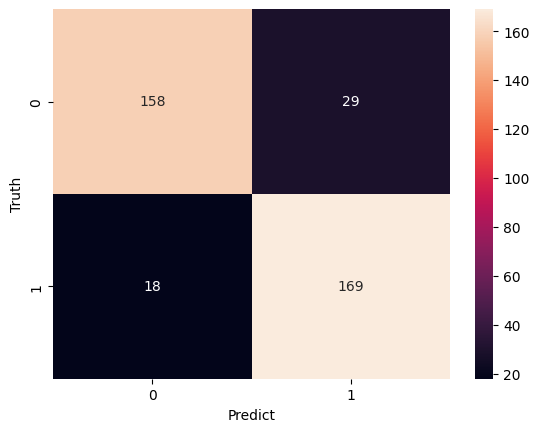

In [62]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred)
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predict')
plt.ylabel('Truth')

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       187
           1       0.85      0.90      0.88       187

    accuracy                           0.87       374
   macro avg       0.88      0.87      0.87       374
weighted avg       0.88      0.87      0.87       374



In [64]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 986ms/step


array([[0.66395795],
       [0.69162667],
       [0.7103908 ],
       [0.27144548],
       [0.16331449]], dtype=float32)